In [41]:
import random

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tqdm
import torchvision.transforms.functional as F

from torch import device

if torch.backends.mps.is_available():
    device = torch.device("mps")  # GPU на Mac (Apple Silicon або AMD)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU (не на Mac)
    print(
        f"GPU count: {torch.cuda.device_count()}"
        f", CUDA version: {torch.version.cuda}"
        f", cuDNN version: {torch.backends.cudnn.version()}"
    )
else:
    device = torch.device("cpu")  # fallback

print("Using GPU:", device)

Using GPU: cpu


In [42]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [43]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.dbl_conv = DoubleConvolution(in_channels, out_channels)
        self.dwn_samp = nn.MaxPool2d(2,2)

    def forward(self, x):
        down = self.dbl_conv(x)
        p = self.dwn_samp(down)

        return down, p


In [44]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_samp = nn.ConvTranspose2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=2, stride=2)
        self.dbl_conv = DoubleConvolution(in_channels, out_channels)

    def forward(self, x1, x2):
        out = self.up_samp(x1)
        out = torch.cat([out, x2], 1)
        return self.dbl_conv(out)


In [45]:

class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.dwn_lr1 = DownSample(3, 64)
        self.dwn_lr2 = DownSample(64, 128)
        self.dwn_lr3 = DownSample(128, 256)
        self.dwn_lr4 = DownSample(256, 512)

        self.dbl_conv = DoubleConvolution(512, 1024)

        self.up_lr1 = UpSample(1024, 512)
        self.up_lr2 = UpSample(512, 256)
        self.up_lr3 = UpSample(256, 128)
        self.up_lr4 = UpSample(128, 64)

        self.conv_1x1 = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1, padding=1)

    def forward(self, x):
        skip ,out = self.dwn_lr1(x)
        skip1, out = self.dwn_lr2(out)
        skip2, out = self.dwn_lr3(out)
        skip3, out = self.dwn_lr4(out)

        out = self.dbl_conv(out)

        out = self.up_lr1(out, skip3)
        out = self.up_lr2(out, skip2)
        out = self.up_lr3(out, skip1)
        out = self.up_lr4(out, skip)

        return self.conv_1x1(out)

In [52]:
def random_color_jitter(img):
    brightness = random.uniform(0.8, 1.2)
    contrast = random.uniform(0.8, 1.2)
    saturation = random.uniform(0.8, 1.2)
    hue = random.uniform(-0.1, 0.1)

    img = F.adjust_brightness(img, brightness)
    img = F.adjust_contrast(img, contrast)
    img= F.adjust_saturation(img, saturation)
    img = F.adjust_hue(img, hue)
    return img


class SegmentationTransformation:
    def __init__(self, size=(256, 256)):
        self.size = size

    def __call__(self, img, mask):
        if random.random() < 0.5:
            img = F.hflip(img)
            mask = F.hflip(mask)

        img = F.pad(img, padding=[8])
        mask = F.pad(mask, padding=[8])


        i, j, h ,w = transforms.RandomCrop.get_params(img, (min(img.height, 192), min(img.width, 192)))
        img = F.crop(img, i, j ,h , w)
        mask = F.crop(mask, i, j, h, w)

        img = random_color_jitter(img)

        img = F.resize(img, size=self.size, interpolation=transforms.InterpolationMode.BILINEAR)
        mask = F.resize(mask, size=self.size, interpolation=transforms.InterpolationMode.NEAREST)

        img = F.to_tensor(img)
        img = F.normalize(img, [0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
        mask = F.pil_to_tensor(mask)

        return img, mask

class SegmentationTestTransformation:
    def __init__(self, size=(256, 256)):
        self.size = size

    def __call__(self, img, mask):
        img = F.resize(img, self.size, interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
        mask = F.resize(mask, self.size, interpolation=torchvision.transforms.InterpolationMode.NEAREST)

        img = F.to_tensor(img)
        img = F.normalize(img, [0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
        mask = F.pil_to_tensor(mask)

        return img, mask

In [53]:


train_dataset = torchvision.datasets.VOCSegmentation(root='./data', year='2012', image_set='train', download=False, transforms=SegmentationTransformation())

test_dataset = torchvision.datasets.VOCSegmentation(root='./data', year='2012', image_set='val', download=False, transforms=SegmentationTestTransformation())

In [54]:
batch_size = 8
num_workers = 0

pin_memory = True if(torch.cuda.is_available()) else False

In [56]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)


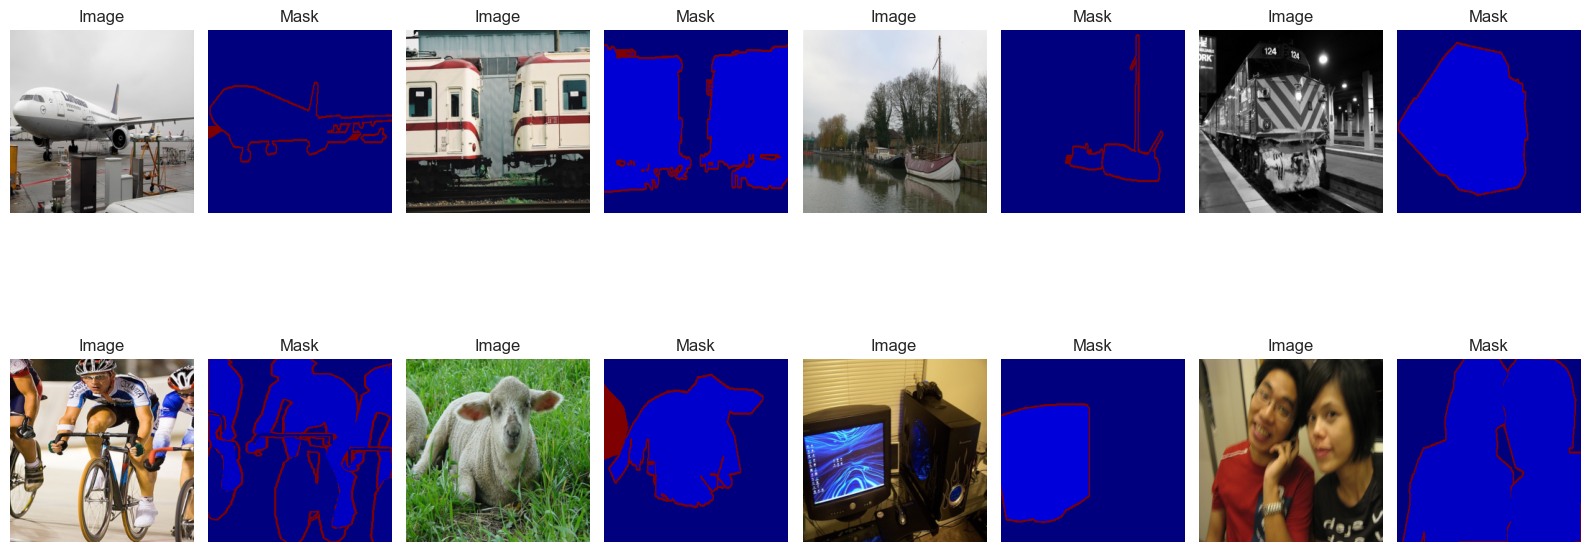

In [57]:

def show_batch_images_masks(images, masks, n=8):
    """
    Показує перші n зображень та масок з батчу.
    images: тензор [B, C, H, W]
    masks: тензор [B, 1, H, W]
    """
    n = min(n, images.size(0))  # не більше розміру батчу
    cols = 4
    rows = (n + cols - 1) // cols  # округлення вгору

    plt.figure(figsize=(cols*4, rows*4))

    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = img.clip(0, 1)

        mask = masks[i].squeeze().numpy()

        plt.subplot(rows, cols*2, i*2 + 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(rows, cols*2, i*2 + 2)
        plt.imshow(mask, cmap='jet')
        plt.title("Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Візьмемо один батч
images, masks = next(iter(test_loader))

# Показуємо перші 8
show_batch_images_masks(images, masks, n=8)

